In [1]:
import dgl
import torch
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

## 1.Nodes

In [413]:
# 构建点
# 读取所有 CSV 文件, 分开存放后期容易分析
# df2 = pd.read_csv('E:/Dataset/GNN_Perception/Graph/road2/total_feature_vit.csv')
df3 = pd.read_csv('E:/Dataset/GNN_Perception/Graph/road2/poi.csv')
df4 = pd.read_csv('E:/Dataset/GNN_Perception/Graph/road2/function.csv')
df5 = pd.read_csv('E:/Dataset/GNN_Perception/Graph/road2/spatial.csv')
df6 = pd.read_csv('E:/Dataset/GNN_Perception/Graph/road2/houseprice.csv')
df7 = pd.read_csv('E:/Dataset/GNN_Perception/Graph/road2/total_feature.csv')

# 将所有特征拼接成一个张量
features = torch.cat([
    # torch.tensor(df.to_numpy())[:, 1:].float(),
    # torch.tensor(df1.to_numpy())[:, 1:].float(),
    
    # torch.tensor(np.array(df2.iloc[:, 2:].values.tolist(), dtype=np.float32)),
    torch.tensor(df3.to_numpy())[:, 1:].float(),
    torch.tensor(df4.to_numpy())[:, 2:].float(),
    torch.tensor(df5.to_numpy())[:, 1:].float(),
    torch.tensor(df6.to_numpy())[:, 1:].float(),
    torch.tensor(df7.to_numpy())[:, 1:].float(),
], dim=1)

x = torch.tensor(features, dtype=torch.float)
x,x.shape

C:\Users\Asus\AppData\Local\Temp\ipykernel_26956\3219143856.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(features, dtype=torch.float)


(tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.1667, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0667, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.1250, 0.0000, 0.1000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0500,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]),
 torch.Size([5075, 291]))

In [414]:
G = dgl.DGLGraph()
G

d:\anaconda3\envs\pytorch\lib\site-packages\dgl\heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


Graph(num_nodes=0, num_edges=0,
      ndata_schemes={}
      edata_schemes={})

In [415]:
# 添加节点并设置节点特征
num_nodes = len(df3)
G.add_nodes(num_nodes)
G.ndata['features'] = x
G

Graph(num_nodes=5075, num_edges=0,
      ndata_schemes={'features': Scheme(shape=(291,), dtype=torch.float32)}
      edata_schemes={})

## 2.Edges

In [416]:
## 注意！！每执行一次都会重复添加
# edge_data = pd.read_csv('E:/Dataset/GNN_Perception/Graph/hex/edge_hex_k.csv')
# edge_data = pd.read_csv('E:/Dataset/GNN_Perception/Graph/hex/edge_hex_queen.csv')
# edge_data = pd.read_csv('E:/Dataset/GNN_Perception/Graph/hex/edge_hex_rook.csv')
edge_data = pd.read_csv('E:/Dataset/GNN_Perception/Graph/road2/k5.csv')

src = edge_data['src'].tolist()
dst = edge_data['dst'].tolist()

## 注意图的序号是从0开始的
G.add_edges(src, dst)
G

Graph(num_nodes=5075, num_edges=25375,
      ndata_schemes={'features': Scheme(shape=(291,), dtype=torch.float32)}
      edata_schemes={})

In [13]:
## 添加边权重
edge_weight = torch.tensor(edge_data['weight'].to_numpy()).float()

G.edata['weight'] = edge_weight
G

Graph(num_nodes=5075, num_edges=25375,
      ndata_schemes={'features': Scheme(shape=(291,), dtype=torch.float32)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float32)})

## 3.Training Data

In [417]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import numpy as np

df = pd.read_csv('E:/Dataset/GNN_Perception/Graph/road2/label.csv')
# df = pd.read_csv('E:/Dataset/GNN_Perception/Graph/road2/label_5.csv')

# 把non值去掉
df.dropna(subset=['label'], inplace=True)

# 平衡数据，把数量过多的标签删除
label_1 = df[df['label'] == 1]
num_rows_to_remove = int(len(label_1) * 0.5)
rows_to_remove = np.random.choice(label_1.index, num_rows_to_remove, replace=False)
df = df.drop(rows_to_remove)
# 平衡数据，把数量过多的标签删除
# label_1 = df[df['label'] == 2]
# num_rows_to_remove = int(len(label_1) * 0.3)
# rows_to_remove = np.random.choice(label_1.index, num_rows_to_remove, replace=False)
# df = df.drop(rows_to_remove)

# 将节点 ID 设置为 '_ID' 特征属性
G.ndata['_ID'] = torch.arange(num_nodes)

# 创建 'label' 特征属性，并将所有节点的标签初始化为0
G.ndata['label'] = torch.zeros(num_nodes, dtype=torch.long)

# 遍历每个节点 ID 并将其对应的标签赋值到图 G 上的节点
for node_id in df.index:
    if node_id in G.ndata['_ID']:
        label = df.loc[node_id, 'label']
        G.ndata['label'][G.ndata['_ID'] == node_id] = label

# 上采样数据以平衡类别
ros = RandomOverSampler(random_state=0)
X = df.drop(['label'], axis=1)
y = df['label']
X_resampled, y_resampled = ros.fit_resample(X, y)

# 将上采样后的数据转换为DataFrame格式
df_resampled = pd.DataFrame(
    data=np.column_stack((X_resampled, y_resampled)),
    columns=[*X.columns, 'label']
)

# 划分训练集和测试集（比例0.2）
train_node_ids, test_node_ids = train_test_split(df.index, test_size=0.2, stratify=df['label'])

# 创建 'train_mask' 和 'test_mask' 特征属性，并将它们初始化为 False
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_node_ids] = True
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask[test_node_ids] = True

G.ndata['train_mask'] = train_mask
G.ndata['test_mask'] = test_mask

In [418]:
g = G
labels = G.ndata['label']
features = G.ndata['features']
train_mask = G.ndata['train_mask']
test_mask = G.ndata['test_mask']

# 使用 PyTorch 的 unique() 方法获取所有不同的标签
unique_labels = torch.unique(G.ndata['label'])

# 统计每个不同的标签在 labels 中的出现次数
for label in unique_labels:
    count = (labels == label).sum().item()
    print(f"Label {label}: {count}")

Label 0: 3960
Label 1: 434
Label 2: 359
Label 3: 322


In [419]:
g = dgl.add_self_loop(g)

In [420]:
labels,train_mask,test_mask

(tensor([0, 0, 0,  ..., 0, 0, 0]),
 tensor([False, False, False,  ..., False, False, False]),
 tensor([False, False, False,  ..., False, False, False]))

## 4.Training！

### 4.1 GCN

In [369]:
# 2 layers

import dgl.nn.pytorch as dglnn
import torch.nn as nn

class GCN(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats, dropout):
        super().__init__()
        
        # First GCN layer
        self.conv1 = dglnn.GraphConv(in_feats, hidden_feats)
        
        # Second GCN layer
        self.conv2 = dglnn.GraphConv(hidden_feats, out_feats)
        
        # ReLU activation
        self.relu = nn.ReLU()
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, g, x):
        # First GCN layer
        h = self.conv1(g, x)

        # ReLU activation and dropout
        h = self.dropout(self.relu(h))
        
        # Second GCN layer
        h = self.conv2(g, h)
        
        return h

### 4.2 GCN2

In [370]:
# 3 layers

import dgl.nn.pytorch as dglnn
import torch.nn as nn

class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size1, hidden_size2, out_feats, dropout):
        super().__init__()
        
        # First GCN layer
        self.conv1 = dglnn.GraphConv(in_feats, hidden_size1)
        
        # Second GCN layer
        self.conv2 = dglnn.GraphConv(hidden_size1, hidden_size2)
        
        # Third GCN layer
        self.conv3 = dglnn.GraphConv(hidden_size2, out_feats)
        
        # ReLU activation
        self.relu = nn.ReLU()
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, g, x):
        # First GCN layer
        h = self.conv1(g, x)

        # ReLU activation and dropout
        h = self.dropout(self.relu(h))
        
        # Second GCN layer
        h = self.conv2(g, h)
        
        # ReLU activation and dropout
        h = self.dropout(self.relu(h))
        
        # Third GCN layer
        h = self.conv3(g, h)
        
        return h


### 4.3 SAG

In [371]:
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import GraphConv

class SAGELayer(nn.Module):
    def __init__(self, in_feats, out_feats, dropout_rate):
        super(SAGELayer, self).__init__()
        self.conv = GraphConv(in_feats=in_feats, out_feats=out_feats)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, g, feature):
        h = self.conv(g, feature)
        h = F.relu(h)
        h = self.dropout(h)
        return h

class SAGE(nn.Module):
    def __init__(self, in_feats, hidden_feats1, hidden_feats2, out_feats, dropout_rate):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(in_feats=in_feats, out_feats=hidden_feats1, dropout_rate=dropout_rate))
        self.layers.append(SAGELayer(in_feats=hidden_feats1, out_feats=hidden_feats2, dropout_rate=dropout_rate))
        self.layers.append(SAGELayer(in_feats=hidden_feats2, out_feats=out_feats, dropout_rate=dropout_rate))

    def forward(self, g, feature):
        h = feature
        for layer in self.layers:
            h = layer(g, h)
        return h
    
# model = SAGE(291, 32, 16, 4, 0.2) 

### 4.4 GAT

In [240]:
import dgl.nn.pytorch as dglnn
import torch.nn as nn

class GAT(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats, num_heads1, num_heads2, dropout):
        super().__init__()
        
        # First GAT layer
        self.conv1 = dglnn.GATConv(in_feats, hidden_feats, num_heads=num_heads1)
        
        # Second GAT layer
        self.conv2 = dglnn.GATConv(hidden_feats * num_heads1, out_feats, num_heads=num_heads2)
        
        # ReLU activation
        self.relu = nn.ReLU()
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, g, x):
        # First GAT layer
        h = self.conv1(g, x).flatten(1)

        # ReLU activation and dropout
        h = self.dropout(self.relu(h))
        
        # Second GAT layer
        h = self.conv2(g, h).mean(1)
        
        return h

In [227]:
import dgl.nn.pytorch as dglnn
import torch.nn as nn

class GCN(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats, dropout):
        super().__init__()
        
        # First GCN layer
        self.conv1 = dglnn.GraphConv(in_feats, hidden_feats)
        
        # Multi-head attention layer
        self.attn = nn.MultiheadAttention(hidden_feats, num_heads=8)

        # Second GCN layer
        self.conv2 = dglnn.GraphConv(hidden_feats, out_feats)
        
        # ReLU activation
        self.relu = nn.ReLU()
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, g, x):
        # First GCN layer
        h = self.conv1(g, x)

        # Multi-head attention layer
        h, _ = self.attn(h, h, h)

        # ReLU activation and dropout
        h = self.dropout(self.relu(h))
        
        # Second GCN layer
        h = self.conv2(g, h)
        
        return h

### 4.5 Training Parameter

In [382]:
%%time
# 定义训练函数
def train(model, g, features, labels, train_mask, loss_func, optimizer):
    model.train()

    logits = model(g, features)
    train_labeled = labels[train_mask]

    # 计算损失
    loss = loss_func(logits[train_mask], train_labeled)

    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

# 在test函数中添加计算F1值的代码
def test(model, g, features, labels, test_mask):
    model.eval()
    with torch.no_grad():
        logits = model(g, features)
        test_labeled = labels[test_mask]
        _, predicted = torch.max(logits[test_mask], 1)
        
        # 计算精确度和召回率
        tp = ((predicted == test_labeled) & (test_labeled == 1)).sum().item()
        fp = ((predicted != test_labeled) & (test_labeled == 0)).sum().item()
        fn = ((predicted != test_labeled) & (test_labeled == 1)).sum().item()

        # precision = tp / (tp + fp)
        # recall = tp / (tp + fn)

        correct = (predicted == test_labeled).sum().item()
        acc = correct / len(test_labeled)

        # 计算F1值
        # f1 = 2 * (precision * recall) / (precision + recall)

        # 记录预测结果和真实标签
        predictions = predicted.cpu().numpy()
        true_labels = test_labeled.cpu().numpy()

        print('Accuracy: {:.4f}'.format(acc))
        # print('Precision: {:.4f}'.format(precision))
        # print('Recall: {:.4f}'.format(recall))
        # print('F1 Score: {:.4f}'.format(f1))

        return predictions, true_labels

# 训练模型
# model = GCN(255, 16, 4, 0.2) # 输入特征维度为36，中间层特征维度为16，输出特征维度为3  ，，修改模型  注意！！输出维度一定要和节点特征的维度一致
# model = GCN(255, 32, 16, 4, 0.2)
# model = SAGE(255, 32, 16, 4, 0.4) 
model = GAT(255, 16, 4, 8, 12, 0.2)
# model = GAT(291, 16, 4, 0.2)

loss_func = nn.CrossEntropyLoss() # 使用交叉熵损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # 使用Adam优化器

# 存储每个epoch的损失值
train_losses = []

for epoch in range(501):
    loss = train(model, g, g.ndata['features'], g.ndata['label'], g.ndata['train_mask'], loss_func, optimizer)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    train_losses.append(loss)
    
    predictions, true_labels = test(model, g, g.ndata['features'], g.ndata['label'], g.ndata['test_mask'])
    # logger.info('Epoch {:d} | Loss {:.4f}'.format(epoch, loss))

Epoch: 000, Loss: 1.3812
Accuracy: 0.3991
Epoch: 001, Loss: 1.2956
Accuracy: 0.4081
Epoch: 002, Loss: 1.2238
Accuracy: 0.3946
Epoch: 003, Loss: 1.1650
Accuracy: 0.3901
Epoch: 004, Loss: 1.1240
Accuracy: 0.3901
Epoch: 005, Loss: 1.1027
Accuracy: 0.3946
Epoch: 006, Loss: 1.0873
Accuracy: 0.4215
Epoch: 007, Loss: 1.0777
Accuracy: 0.4529
Epoch: 008, Loss: 1.0720
Accuracy: 0.4126
Epoch: 009, Loss: 1.0660
Accuracy: 0.4036
Epoch: 010, Loss: 1.0569
Accuracy: 0.4126
Epoch: 011, Loss: 1.0577
Accuracy: 0.4709
Epoch: 012, Loss: 1.0487
Accuracy: 0.4529
Epoch: 013, Loss: 1.0440
Accuracy: 0.4484
Epoch: 014, Loss: 1.0355
Accuracy: 0.4439
Epoch: 015, Loss: 1.0299
Accuracy: 0.4619
Epoch: 016, Loss: 1.0209
Accuracy: 0.4709
Epoch: 017, Loss: 1.0201
Accuracy: 0.4619
Epoch: 018, Loss: 1.0084
Accuracy: 0.4350
Epoch: 019, Loss: 1.0161
Accuracy: 0.4664
Epoch: 020, Loss: 1.0033
Accuracy: 0.4843
Epoch: 021, Loss: 0.9987
Accuracy: 0.4753
Epoch: 022, Loss: 0.9831
Accuracy: 0.4709
Epoch: 023, Loss: 0.9770
Accuracy:

In [376]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score


predictions, true_labels = test(model, g, g.ndata['features'], g.ndata['label'], g.ndata['test_mask'])

# 计算混淆矩阵
conf_mat = confusion_matrix(true_labels, predictions)

# 计算精确度、召回率和F1分数
precision = precision_score(true_labels, predictions, average='macro')
recall = recall_score(true_labels, predictions, average='macro')
f1 = f1_score(true_labels, predictions, average='macro')

print('Confusion Matrix:\n', conf_mat)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Accuracy: 0.6368
Confusion Matrix:
 [[70  9  8]
 [22 38 12]
 [17 13 34]]
Precision: 0.6350549326084495
Recall: 0.6212084929757343
F1 Score: 0.622104825494656


In [428]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score


predictions, true_labels = test(model, g, g.ndata['features'], g.ndata['label'], g.ndata['test_mask'])

# 计算混淆矩阵
conf_mat = confusion_matrix(true_labels, predictions)

# 计算精确度、召回率和F1分数
precision = precision_score(true_labels, predictions, average='macro')
recall = recall_score(true_labels, predictions, average='macro')
f1 = f1_score(true_labels, predictions, average='macro')

print('Confusion Matrix:\n', conf_mat)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Accuracy: 0.7354
F1 Score: 0.8477
Confusion Matrix:
 [[64 13 10]
 [13 53  6]
 [ 6 11 47]]
Precision: 0.7351425905642773
Recall: 0.7353727650063857
F1 Score: 0.7348360175862344


In [48]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels, predictions)
cm

array([[45, 23,  3],
       [15, 47,  3],
       [ 7,  5,  9]], dtype=int64)

### 4.6 Prediction

In [49]:
# 预测剩下的点
out = model(g,g.ndata['features'])  #输出output layer dimension 4
pred = out.argmax(dim=1)

d:\anaconda3\envs\pytorch\lib\site-packages\dgl\backend\pytorch\tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In [13]:
out

tensor([[-25.0023, -13.1183,   6.9001,  17.2436],
        [ -9.1107,   2.6718,   3.2896,  -0.3685],
        [-13.1571,  -5.4639,  -6.1848,  18.9586],
        ...,
        [ -6.7261,   0.6830,   9.4437,  -4.0491],
        [ -7.8390,   1.7754,   8.5815,  -4.0159],
        [-10.3137,  -4.0166,   2.2071,   7.1694]], grad_fn=<MeanBackward1>)

In [50]:
pred
np.savetxt('E:/tensor.csv', pred, delimiter=',')

In [415]:
from sklearn.manifold import TSNE
z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())

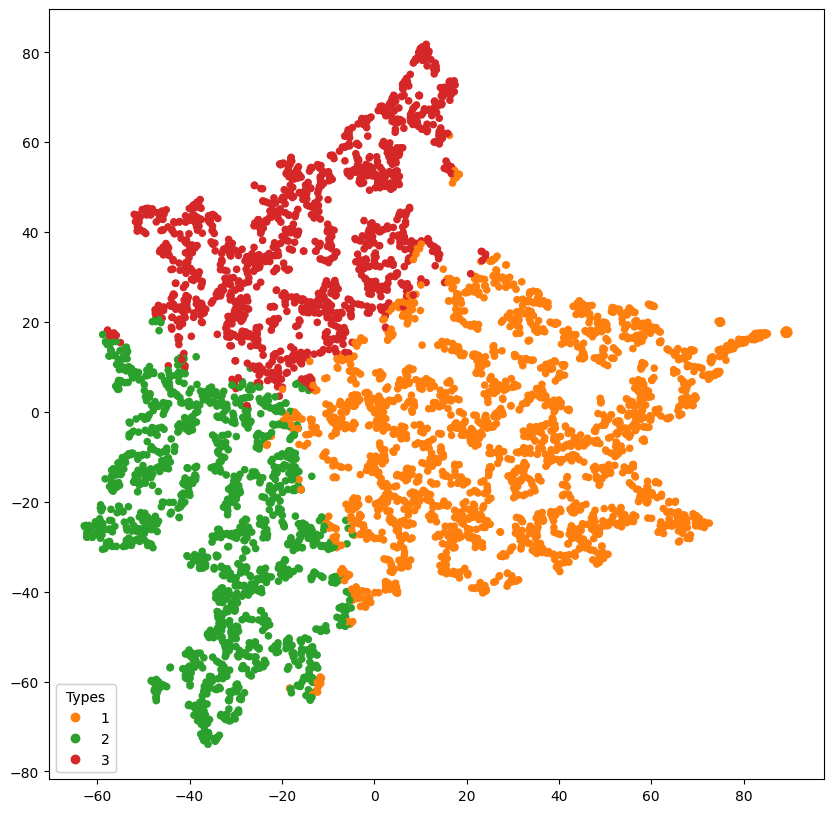

In [416]:
fig, ax = plt.subplots(figsize=(10,10))
scatter = ax.scatter(z[:, 0], z[:, 1], s=20, c=pred, vmin=0, vmax=9, cmap="tab10")
legend1 = ax.legend(*scatter.legend_elements(num=torch.unique(pred)),loc="lower left", title="Types")
ax.add_artist(legend1)
# plt.savefig('E:/Dataset/GNN_Perception/fig_out/kmeansplot.svg')
plt.show()

In [ ]:
G

Graph(num_nodes=10964, num_edges=46170,
      ndata_schemes={'visual_features': Scheme(shape=(36,), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'h_neigh': Scheme(shape=(4,), dtype=torch.float32)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float32)})

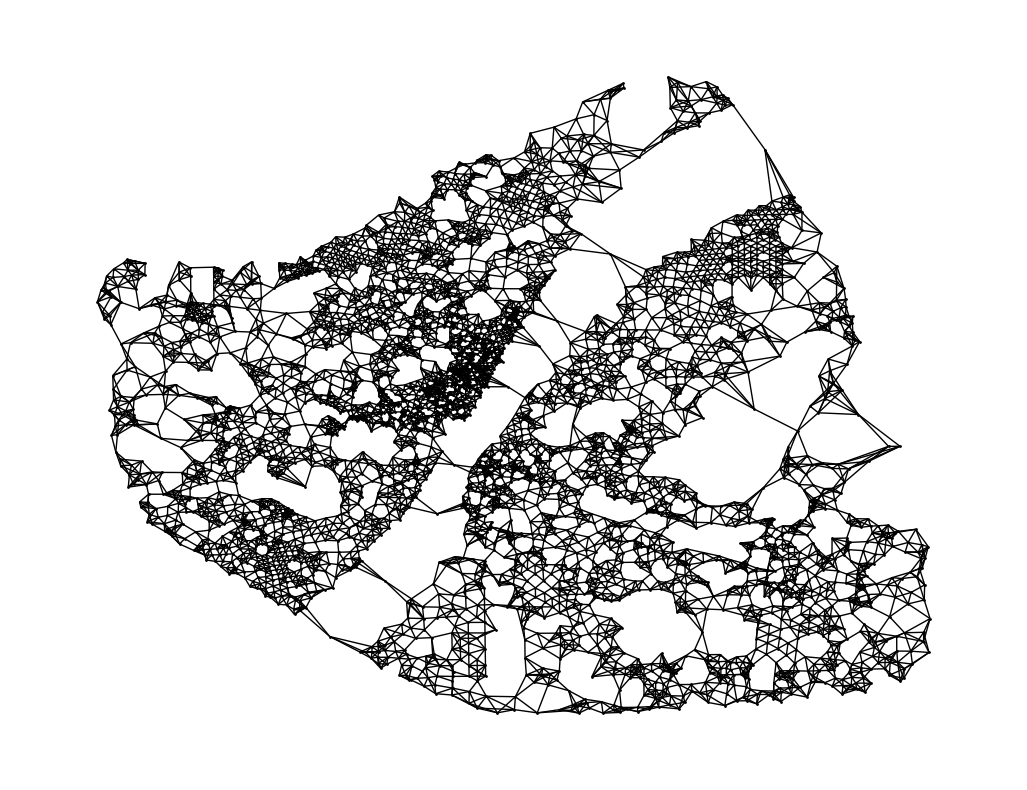

In [23]:
#可视化一下
nx_G = G.to_networkx()
fig, ax = plt.subplots(figsize=(13,10))
# 储存了点的坐标，注意要从0开始
df2=pd.read_csv('E:/Dataset/GNN_Perception/Graph/road2/node.csv')
pos_dict = {}
for i, row in df2.iterrows():
    pos_dict[row['id']] = (row['x'], row['y'])  #其中'X'和'Y'是坐标信息所在的列名
    
nx.draw(nx_G.to_undirected(), pos = pos_dict, with_labels=False, node_size=1, node_color='black')
plt.savefig('E:/Dataset/GNN_Perception/fig_out/network.svg',format='svg',bbox_inches='tight')
plt.show()

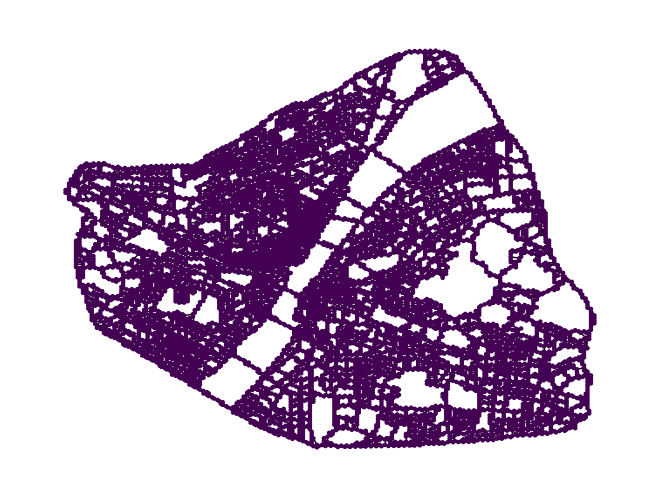

In [76]:
#可视化一下
nx_G2 = G2.to_networkx()

# 储存了点的坐标，注意要从0开始
df2=pd.read_csv('E:/Dataset/GNN_Perception/Graph/hex/node_hex.csv')
pos_dict = {}
for i, row in df2.iterrows():
    pos_dict[row['id']] = (row['x'], row['y'])  #其中'X'和'Y'是坐标信息所在的列名
    
nx.draw(nx_G2.to_undirected(), pos = pos_dict, with_labels=False, node_size=5, node_color=pred)
plt.show()

### 4.7 Confusion matrix

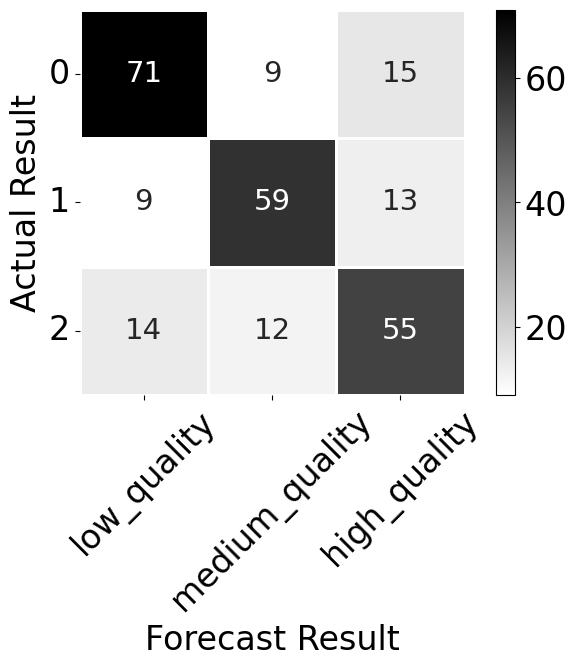

In [285]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels, predictions)

## 绘制混淆矩阵
import seaborn as sns
import matplotlib.pyplot as plt
df_cm=pd.DataFrame(cm,
columns=["low_quality","medium_quality","high_quality"])#&Transport
# plt.figure(figsize=(10,8))
f, ax= plt.subplots(figsize = (8, 5))
 
h=sns.heatmap(df_cm,annot=True,cmap="binary",fmt='.20g',ax=ax,linewidths=2,
            annot_kws={'size':21},cbar=False,square=True)
 
#h=sns.heatmap(data, annot=True,fmt='d',linewidths=0.5,cbar=False) #设置不使用其默认自带的colorbar
cb=h.figure.colorbar(h.collections[0]) #显示colorbar
cb.ax.tick_params(labelsize=24) #设置colorbar刻度字体大小。
 
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
 
ax.tick_params(labelsize=24)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
 
plt.ylabel('Actual Result',fontsize=24)
plt.xlabel('Forecast Result',fontsize=24)
# plt.savefig('E:/Dataset/GNN_Perception/fig_out/confmatrix.svg',format='svg',bbox_inches='tight')
plt.show()

## 5. Tradition model

In [395]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# 从本地读取CSV文件并创建数据帧
data = pd.read_csv('E:/Dataset/GNN_Perception/Graph/total.csv')
# print(data.head(2))

# 将特征列保存到X变量中
X = data.iloc[:,2:].values

# 将目标列保存到y变量中
y = data.iloc[:,1].values

print(X,y)

# 划分数据集，设置测试集占比为0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

[[-0.0419     -0.0749      0.1295     ...  0.          0.
   0.34961774]
 [-0.5081      0.3789     -0.1409     ...  0.          0.
   0.34168128]
 [ 0.0962      0.2194      0.133      ...  0.          0.
   0.28390485]
 ...
 [ 0.0233     -0.2192      0.1364     ...  0.          0.
   0.44757809]
 [ 0.0747      0.2947     -0.0719     ...  0.          0.
   0.25604801]
 [-0.303      -0.0032     -0.1095     ...  0.          0.
   0.27464055]] [3 1 3 ... 1 1 3]


### GBDT

In [398]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from joblib import Parallel, delayed

# 创建GradientBoostingClassifier模型
gbdt = GradientBoostingClassifier(loss='deviance',
                                  learning_rate=0.01,
                                  n_estimators=5000,
                                  max_depth=15,
                                  max_features='sqrt',
                                  min_samples_leaf=10,
                                  min_samples_split=10,
                                  random_state=50)

# 假设您的数据保存在X和y变量中
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 将评估函数包装为带有y_true参数的函数
def evaluate_model(y_true, X_train, y_train, X_test):
    gbdt.fit(X_train, y_train)
    y_pred = gbdt.predict(X_test)
    return f1_score(y_true, y_pred, average='macro')

# 使用并行化加速交叉验证计算
scores = Parallel(n_jobs=-1, verbose=1)(
    delayed(evaluate_model)(y[test_index], X[train_index], y[train_index], X[test_index])
    for train_index, test_index in kf.split(X))

average_Acc = sum(scores) / len(scores) # 计算平均F1分数得分
# print('Accuracy:', average_Acc)

# 使用sklearn的cross_val_score函数实现交叉验证
f1_scores = cross_val_score(gbdt, X, y, cv=kf, scoring='f1_macro', n_jobs=-1)
accuracy = cross_val_score(gbdt, X, y, cv=kf, scoring='accuracy', n_jobs=-1)

f1_scores = f1_scores.mean() # 计算平均F1分数得分
accuracy = accuracy.mean() # 计算平均accuracy分数得分
print(f1_scores, accuracy)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


0.4420332182078738 0.5978244075582002


### MLP

In [400]:
%%time
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', alpha=0.0001, batch_size='auto',
                    learning_rate='constant', learning_rate_init=0.001, max_iter=5000, shuffle=True,
                    random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9,
                    nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9,
                    beta_2=0.999, epsilon=1e-08, n_iter_no_change=10)

def evaluate_model(y_true, X_train, y_train, X_test):
    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_test)
    return f1_score(y_true, y_pred, average='macro')

f1_scores = cross_val_score(mlp, X, y, cv=kf, scoring='f1_macro', n_jobs=-1)
accuracy = cross_val_score(mlp, X, y, cv=kf, scoring='accuracy', n_jobs=-1)

f1_scores = f1_scores.mean() # 计算平均F1分数得分
accuracy = accuracy.mean() # 计算平均accuracy分数得分
print(f1_scores, accuracy)

0.42331380268345287 0.5183881407245015
CPU times: total: 31.2 ms
Wall time: 16.9 s


### SVM

In [406]:
%%time
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from joblib import Parallel, delayed

# 创建SVC模型
svm = SVC(kernel='rbf', C=1, gamma='scale')

# 假设您的数据保存在X和y变量中
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 将评估函数包装为带有y_true参数的函数
def evaluate_model(y_true, X_train, y_train, X_test):
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    return f1_score(y_true, y_pred, average='macro')

# 使用并行化加速交叉验证计算
scores = Parallel(n_jobs=-1, verbose=1)(
    delayed(evaluate_model)(y[test_index], X[train_index], y[train_index], X[test_index])
    for train_index, test_index in kf.split(X))

# 使用sklearn的cross_val_score函数实现交叉验证
f1_scores = cross_val_score(svm, X, y, cv=kf, scoring='f1_macro', n_jobs=-1)
accuracy = cross_val_score(svm, X, y, cv=kf, scoring='accuracy', n_jobs=-1)

f1_scores = f1_scores.mean() # 计算平均F1分数得分
accuracy = accuracy.mean() # 计算平均accuracy分数得分
print(f1_scores, accuracy)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


0.2850523590895169 0.5629773462783172
CPU times: total: 62.5 ms
Wall time: 996 ms


### RF

In [407]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import f1_score
from joblib import Parallel, delayed
import numpy as np

# 创建RandomForestClassifier模型
rf = RandomForestClassifier(n_estimators=5000,
                             criterion='gini',
                             max_depth=15,
                             min_samples_split=10,
                             min_samples_leaf=10,
                             max_features='sqrt',
                             random_state=50)

# 假设您的数据保存在X和y变量中
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 将评估函数包装为带有y_true参数的函数
def evaluate_model(y_true, X_train, y_train, X_test):
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    return f1_score(y_true, y_pred, average='macro')

# 使用并行化加速交叉验证计算
scores = Parallel(n_jobs=-1, verbose=1)(
    delayed(evaluate_model)(y[test_index], X[train_index], y[train_index], X[test_index])
    for train_index, test_index in kf.split(X))

average_f1_score = np.mean(scores) # 计算平均F1分数得分
# print('F1 Score:', average_f1_score)

# 使用sklearn的cross_val_score函数实现交叉验证
f1_scores = cross_val_score(rf, X, y, cv=kf, scoring='f1_macro', n_jobs=-1)
accuracy = cross_val_score(rf, X, y, cv=kf, scoring='accuracy', n_jobs=-1)

f1_scores = np.mean(f1_scores) # 计算平均F1分数得分
accuracy = np.mean(accuracy) # 计算平均accuracy分数得分
print(f1_scores, accuracy)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.4s finished


0.28835475616689454 0.5681344607996659
CPU times: total: 31.2 ms
Wall time: 43.3 s


### DF

In [412]:
%%time
from sklearn.model_selection import KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from joblib import Parallel, delayed

# 创建DecisionTreeClassifier模型
dt = DecisionTreeClassifier(criterion='gini', 
                             splitter='best', 
                             max_depth=15, 
                             min_samples_split=10, 
                             min_samples_leaf=10,
                             max_features='sqrt',
                             random_state=50)

# 假设您的数据保存在X和y变量中
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 将评估函数包装为带有y_true参数的函数
def evaluate_model(y_true, X_train, y_train, X_test):
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    return f1_score(y_true, y_pred, average='macro')

# 使用并行化加速交叉验证计算
scores = Parallel(n_jobs=-1, verbose=1)(
    delayed(evaluate_model)(y[test_index], X[train_index], y[train_index], X[test_index])
    for train_index, test_index in kf.split(X))


# 使用sklearn的cross_val_score函数实现交叉验证
f1_scores = cross_val_score(dt, X, y, cv=kf, scoring='f1_macro', n_jobs=-1)
accuracy = cross_val_score(dt, X, y, cv=kf, scoring='accuracy', n_jobs=-1)

f1_scores = f1_scores.mean() # 计算平均F1分数得分
accuracy = accuracy.mean() # 计算平均accuracy分数得分
print(f1_scores, accuracy)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


0.36782579009174404 0.4867627100949995
CPU times: total: 78.1 ms
Wall time: 401 ms


## 5.使用pyg构建图

In [1]:
import torch
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

d:\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 构建边
# edge_data = pd.read_csv('E:/Dataset/GNN_Perception/Graph/hex/edge_hex_queen.csv')
edge_data = pd.read_csv('E:/Dataset/GNN_Perception/Graph/road2/k5.csv')

src = edge_data['src'].tolist()
dst = edge_data['dst'].tolist()

edge_index = torch.tensor([src, dst], dtype=torch.long)
edge_attrs = torch.tensor(edge_data['weight'], dtype=torch.float)
edge_index,edge_index.shape,edge_attrs

(tensor([[4830, 4830, 4830,  ..., 3194, 3194, 3194],
         [4808, 5063, 5003,  ..., 3168, 3195, 3192]]),
 torch.Size([2, 25375]),
 tensor([0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000]))

In [16]:
# 构建点
# 读取所有 CSV 文件, 分开存放后期容易分析
df = pd.read_csv('E:/Dataset/GNN_Perception/Graph/road2/seg.csv')
df1 = pd.read_csv('E:/Dataset/GNN_Perception/Graph/road2/obj.csv')
df2 = pd.read_csv('E:/Dataset/GNN_Perception/Graph/road2/pixel_perception.csv')
df3 = pd.read_csv('E:/Dataset/GNN_Perception/Graph/road2/poi.csv')              #0-22
df4 = pd.read_csv('E:/Dataset/GNN_Perception/Graph/road2/function.csv')         #23-34

df5 = pd.read_csv('E:/Dataset/GNN_Perception/Graph/road2/spatial.csv')          #35-40
df6 = pd.read_csv('E:/Dataset/GNN_Perception/Graph/road2/houseprice.csv')       #41

df7 = pd.read_csv('E:/Dataset/GNN_Perception/Graph/road2/total_feature.csv')    #42-291
df8 = pd.read_csv('E:/Dataset/GNN_Perception/Graph/road2/total_feature_vit.csv')
df9 = pd.read_csv('E:/Dataset/GNN_Perception/Graph/road2/embedding_feature.csv')

# 将所有特征拼接成一个张量
features = torch.cat([
    # torch.tensor(df.to_numpy())[:, 1:].float(),
    # torch.tensor(df1.to_numpy())[:, 1:].float(),
    # torch.tensor(df2.to_numpy())[:, 1:].float(),
    torch.tensor(df3.to_numpy())[:, 1:].float(),      #0-22
    torch.tensor(df4.to_numpy())[:, 2:].float(),      #23-34
    
    # torch.tensor(df5.to_numpy())[:, 1:].float(),      #35-40
    torch.tensor(df6.to_numpy())[:, 1:].float(),      #35

    torch.tensor(df7.to_numpy())[:, 1:].float(),      #36-286
    # torch.tensor(np.array(df8.iloc[:, 2:].values.tolist(), dtype=np.float32))
    # torch.tensor(df9.to_numpy())[:, 2:].float()
], dim=1)

x = torch.tensor(features, dtype=torch.float)
x,x.shape

C:\Users\Asus\AppData\Local\Temp\ipykernel_15068\2625182828.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(features, dtype=torch.float)


(tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.1667, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0667, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.1250, 0.0000, 0.1000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0500,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]),
 torch.Size([5075, 286]))

In [4]:
# 构建数据集
df = pd.read_csv('E:/Dataset/GNN_Perception/Graph/road2/label.csv')

# 把空值替换成-1
df.fillna(-1, inplace=True)

# 平衡数据，把数量过多的标签删除
label_1 = df[df['label'] == 1]
num_rows_to_remove = int(len(label_1) * 0.5)
rows_to_change = np.random.choice(label_1.index, num_rows_to_remove, replace=False)
df.loc[rows_to_change, 'label'] = -1

# 上采样数据以平衡类别
ros = RandomOverSampler(random_state=0)
X = df.drop(['label'], axis=1)
y = torch.tensor(df['label'], dtype=torch.long)
X_resampled, y_resampled = ros.fit_resample(X, y)

# 将上采样后的数据转换为DataFrame格式
df_resampled = pd.DataFrame(
    data=np.column_stack((X_resampled, y_resampled)),
    columns=[*X.columns, 'label']
)

# 过滤掉label中为-1的行
filter_mask = np.where(df['label'] != -1, True, False)

# 划分训练集和测试集
train_node_ids, test_node_ids = train_test_split(
    df.index[filter_mask],
    test_size=0.2,
    stratify=df[filter_mask]['label'],
    random_state=12345
)

# 创建 'train_mask' 和 'test_mask' 特征属性，并将它们初始化为 False
train_mask = torch.zeros(len(x), dtype=torch.bool)
train_mask[train_node_ids] = True
test_mask = torch.zeros(len(x), dtype=torch.bool)
test_mask[test_node_ids] = True

In [5]:
#统计标签数量
from collections import Counter
Counter(df['label']), train_mask.sum().item(), test_mask.sum().item(), y.shape, train_mask.shape, test_mask.shape

(Counter({-1.0: 3960, 3.0: 322, 1.0: 434, 2.0: 359}),
 892,
 223,
 torch.Size([5075]),
 torch.Size([5075]),
 torch.Size([5075]))

In [21]:
data = Data(x=x, edge_index=edge_index,
# edge_attrs = edge_attrs,
y=y,
train_mask=train_mask,
test_mask=test_mask)
data

Data(x=[5075, 286], edge_index=[2, 25375], y=[5075], train_mask=[5075], test_mask=[5075])

In [22]:
y

tensor([-1, -1, -1,  ..., -1, -1, -1])

### 5.2 GCN

In [8]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(286, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 4)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(286, 16)
  (conv2): GCNConv(16, 4)
)


In [8]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, hidden_channel1,hidden_channel2):
        super().__init__()
        torch.manual_seed(1234567)
        
        # Initialize the GCNConv layers with "add_self_loops=False" to ensure that 
        # we don't add self-loops and double count the node features.
        self.conv1 = GCNConv(291, hidden_channel1, add_self_loops=False)
        self.conv2 = GCNConv(hidden_channel1, hidden_channel2, add_self_loops=False)
        self.conv3 = GCNConv(hidden_channel2, 4, add_self_loops=False)

    def forward(self, x, edge_index):
        # Pass edge_weight as an additional argument to each GCNConv layer
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.2, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.2, training=self.training)
        
        x = self.conv3(x, edge_index)
        return x

model = GCN(hidden_channel1=32,hidden_channel2=16)
print(model)


GCN(
  (conv1): GCNConv(291, 32)
  (conv2): GCNConv(32, 16)
  (conv3): GCNConv(16, 4)
)


### 5.3 SAGE

In [27]:
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F

class SAGE(torch.nn.Module):
    def __init__(self, hidden_channel1, hidden_channel2):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = SAGEConv(768, hidden_channel1)
        self.conv2 = SAGEConv(hidden_channel1, hidden_channel2)
        self.conv3 = SAGEConv(hidden_channel2, 4)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv3(x, edge_index)
        return x

model = SAGE(hidden_channel1=32,hidden_channel2=16)
print(model)

SAGE(
  (conv1): SAGEConv(768, 32, aggr=mean)
  (conv2): SAGEConv(32, 16, aggr=mean)
  (conv3): SAGEConv(16, 4, aggr=mean)
)


### 5.4 GAT

In [20]:
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_dim, heads_1=8, heads_2=4, att_dropout=0.2, input_dropout=0):
        super(GAT, self).__init__()
        torch.manual_seed(12345)
        self.att_dropout = att_dropout
        self.input_dropout = input_dropout
        self.conv1 = GATConv(in_channels=286, out_channels=hidden_dim // heads_1,
                             heads=heads_1, concat=True, dropout=att_dropout)
        self.conv2 = GATConv(in_channels=hidden_dim, out_channels=4,
                             heads=heads_2, concat=False, dropout=att_dropout)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.input_dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.input_dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x
    
model = GAT(64)
print(model)


GAT(
  (conv1): GATConv(286, 8, heads=8)
  (conv2): GATConv(64, 4, heads=4)
)


In [35]:
from torch_geometric.nn import GATConv
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.hid = 64
        self.in_head = 8
        self.out_head = 10
        # self.conv1 = GATConv(...)  # TODO
        # self.conv2 = GATConv(...)  # TODO
        self.conv1 = GATConv(250, self.hid, heads=self.in_head, dropout=0.2)

        self.conv2 = GATConv(self.hid*self.in_head,10,concat=False,
                             heads=self.out_head, dropout=0.2)
    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=8, heads=8)
print(model)

GAT(
  (conv1): GATConv(250, 64, heads=8)
  (conv2): GATConv(512, 10, heads=10)
)


### 5.5 Training！

In [30]:
# model = GCN(hidden_channels=16)
# model = GCN(hidden_channel1=32,hidden_channel2=16)
model = SAGE(hidden_channel1=32,hidden_channel2=16)
# model = GAT(32)
# model = GAT(hidden_channels=8, heads=8)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      
      #传递边权重
      out = model(data.x, data.edge_index)
      
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      
      #传递边权重
      out = model(data.x, data.edge_index)
      
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      test_f1 = f1_score(data.y[data.test_mask].cpu().numpy(), pred[data.test_mask].cpu().numpy(), average='macro')
      return test_acc, test_f1

for epoch in range(1, 501):
      loss = train()
      test_acc, test_f1 = test()
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}', f'Test Accuracy: {test_acc:.4f}, Test F1 Score: {test_f1:.4f}')


Epoch: 001, Loss: 1.4178 Test Accuracy: 0.3229, Test F1 Score: 0.1627

Epoch: 002, Loss: 1.4506 Test Accuracy: 0.2825, Test F1 Score: 0.1799

Epoch: 003, Loss: 1.4278 Test Accuracy: 0.3812, Test F1 Score: 0.1840

Epoch: 004, Loss: 1.2882 Test Accuracy: 0.3767, Test F1 Score: 0.1824

Epoch: 005, Loss: 1.2388 Test Accuracy: 0.3812, Test F1 Score: 0.1840

Epoch: 006, Loss: 1.2163 Test Accuracy: 0.3812, Test F1 Score: 0.1840

Epoch: 007, Loss: 1.1857 Test Accuracy: 0.3812, Test F1 Score: 0.1840

Epoch: 008, Loss: 1.1522 Test Accuracy: 0.3857, Test F1 Score: 0.1953

Epoch: 009, Loss: 1.1397 Test Accuracy: 0.3587, Test F1 Score: 0.2851

Epoch: 010, Loss: 1.1392 Test Accuracy: 0.3946, Test F1 Score: 0.2372

Epoch: 011, Loss: 1.1296 Test Accuracy: 0.3857, Test F1 Score: 0.1941

Epoch: 012, Loss: 1.0970 Test Accuracy: 0.3901, Test F1 Score: 0.2291

Epoch: 013, Loss: 1.1262 Test Accuracy: 0.4081, Test F1 Score: 0.2975

Epoch: 014, Loss: 1.1133 Test Accuracy: 0.4036, Test F1 Score: 0.3123

Epoch

KeyboardInterrupt: 

### 5.6 Evaluation

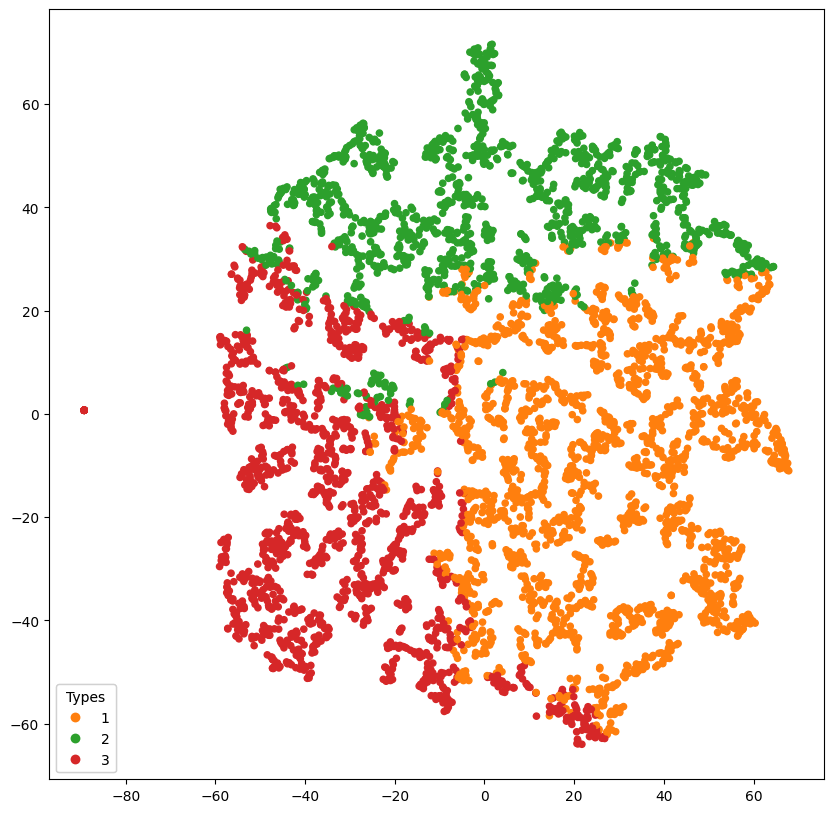

In [11]:
model.eval()

out = model(data.x, data.edge_index)
pred = out.argmax(dim=1)

from sklearn.manifold import TSNE
z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())

fig, ax = plt.subplots(figsize=(10,10))
scatter = ax.scatter(z[:, 0], z[:, 1], s=20, c=pred, vmin=0, vmax=9, cmap="tab10")
legend1 = ax.legend(*scatter.legend_elements(num=torch.unique(pred)),loc="lower left", title="Types")
ax.add_artist(legend1)
# plt.savefig('E:/Dataset/GNN_Perception/fig_out/kmeansplot.svg')
plt.show()

In [68]:
from sklearn.metrics import confusion_matrix
out = model(data.x, data.edge_index)
pred = out.argmax(dim=1)

cm=confusion_matrix(data.y[data.test_mask], pred[data.test_mask])
cm

array([[46, 25, 16],
       [ 7, 60,  5],
       [13, 12, 39]], dtype=int64)

In [13]:
pred
np.savetxt('E:/Dataset/GNN_Perception/fig_out/pred.csv', pred, delimiter=',')

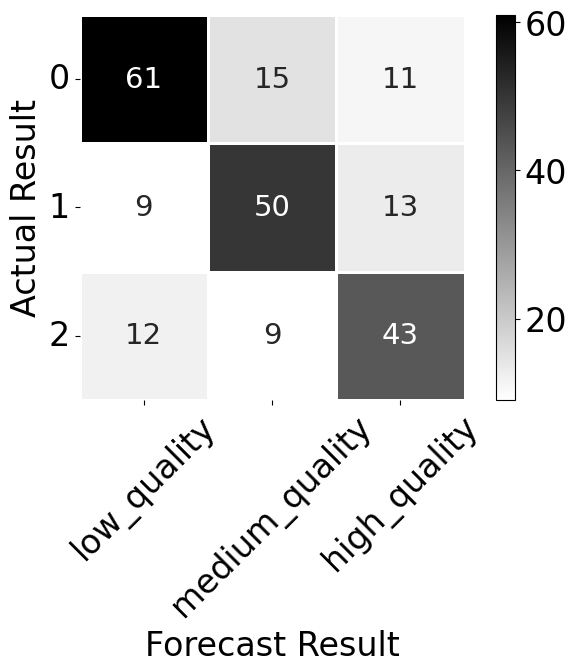

In [13]:
## 绘制混淆矩阵
import seaborn as sns
import matplotlib.pyplot as plt
df_cm=pd.DataFrame(cm,
columns=["low_quality","medium_quality","high_quality"])#&Transport
# plt.figure(figsize=(10,8))
f, ax= plt.subplots(figsize = (8, 5))
 
h=sns.heatmap(df_cm,annot=True,cmap="binary",fmt='.20g',ax=ax,linewidths=2,
            annot_kws={'size':21},cbar=False,square=True)
 
#h=sns.heatmap(data, annot=True,fmt='d',linewidths=0.5,cbar=False) #设置不使用其默认自带的colorbar
cb=h.figure.colorbar(h.collections[0]) #显示colorbar
cb.ax.tick_params(labelsize=24) #设置colorbar刻度字体大小。
 
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
 
ax.tick_params(labelsize=24)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
 
plt.ylabel('Actual Result',fontsize=24)
plt.xlabel('Forecast Result',fontsize=24)
# plt.savefig('E:/Dataset/GNN_Perception/fig_out/confmatrix.svg',format='svg',bbox_inches='tight')
plt.show()

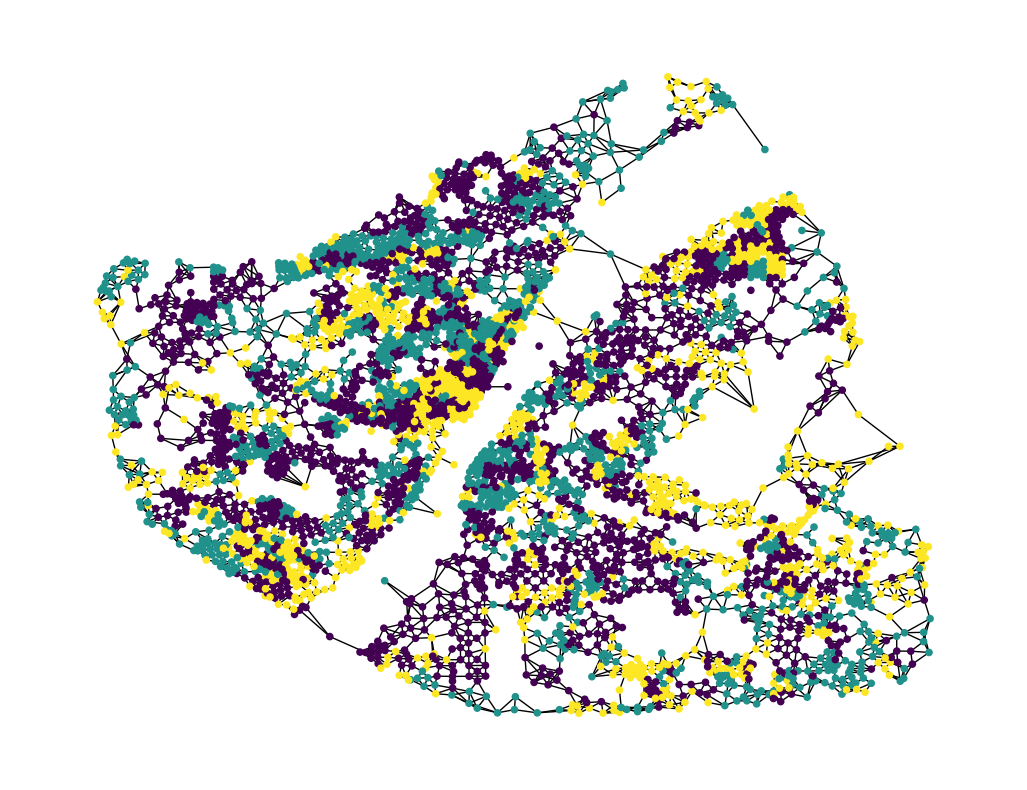

In [69]:
from torch_geometric.utils import to_networkx
import networkx as nx

G = to_networkx(data, to_undirected=True)

fig, ax = plt.subplots(figsize=(13,10))
# 储存了点的坐标，注意要从0开始
df2=pd.read_csv('E:/Dataset/GNN_Perception/Graph/road2/node.csv')
pos_dict = {}
for i, row in df2.iterrows():
    pos_dict[row['id']] = (row['x'], row['y'])  #其中'X'和'Y'是坐标信息所在的列名
    
nx.draw(G, pos = pos_dict, with_labels=False, node_size=20, node_color=pred)
plt.show()

### 5.7 Explaine

In [18]:
from torch_geometric.explain import Explainer, GNNExplainer

# model = GCN(hidden_channels=16)
# model = GCN(hidden_channel1=32,hidden_channel2=16)
model = GAT(64)

explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',  # Model returns log probabilities.
    ),
)

In [23]:
# Generate explanation for the node:
explanation = explainer(data.x, data.edge_index, index=2132)
print(explanation.edge_mask)
print(explanation.node_mask)

tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [27]:
kk = explanation.edge_mask

In [ ]:
# df3 = pd.read_csv('E:/Dataset/GNN_Perception/Graph/road2/poi.csv')              #0-22
# df4 = pd.read_csv('E:/Dataset/GNN_Perception/Graph/road2/function.csv')         #23-34
# df6 = pd.read_csv('E:/Dataset/GNN_Perception/Graph/road2/houseprice.csv')       #35

# df7 = pd.read_csv('E:/Dataset/GNN_Perception/Graph/road2/total_feature.csv')    #36-286

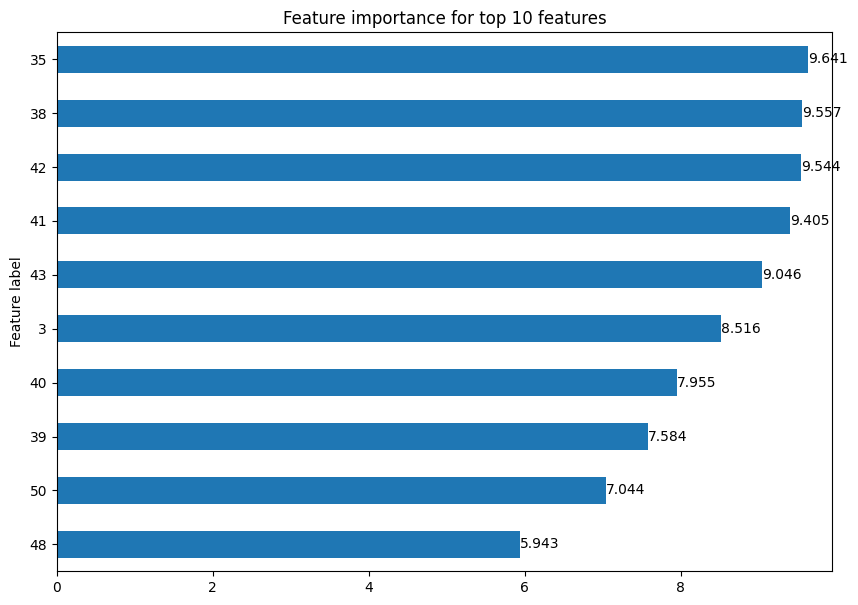

In [25]:
explanation.visualize_feature_importance(top_k=10)

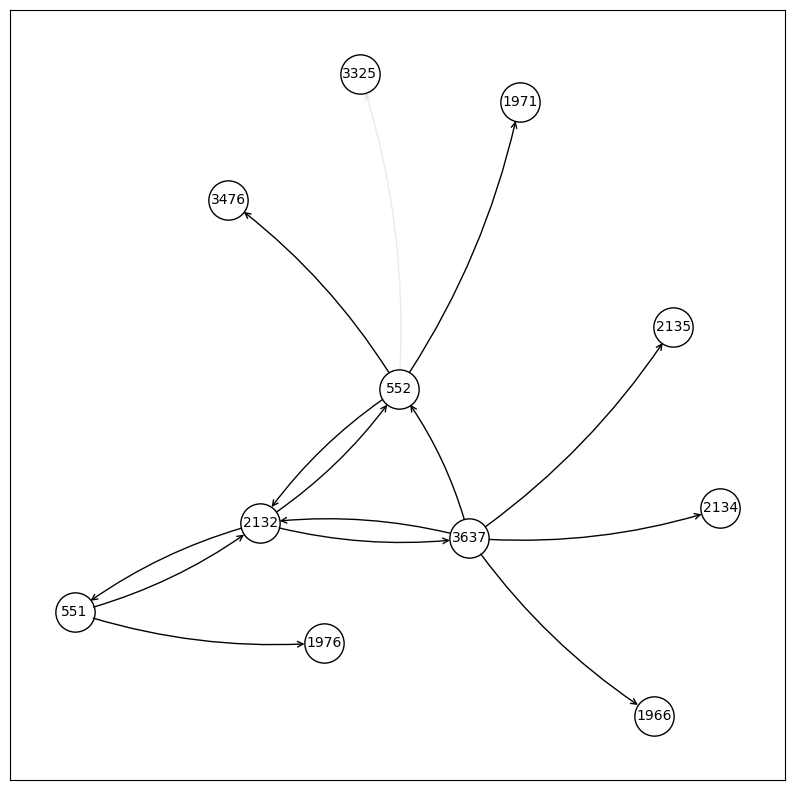

In [26]:
fig= plt.subplots(figsize=(10,10))
explanation.visualize_graph()

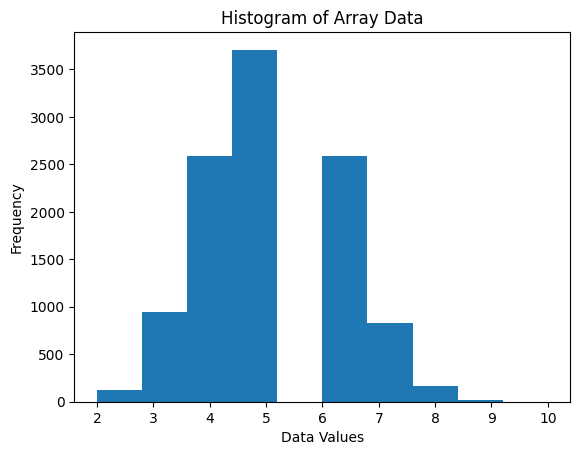

In [110]:
import numpy as np
import torch_geometric.transforms as T
from torch_geometric.utils import degree

# data = T.NormalizeFeatures()(data)
data.degrees = degree(data.edge_index[1], num_nodes=data.num_nodes)
kk = data.degrees

plt.hist(data.degrees)  # 将数据传递给hist函数，并指定bin的数量
plt.title("Histogram of Array Data")  # 设置标题
plt.xlabel("Data Values")  # 设置x轴标签
plt.ylabel("Frequency")  # 设置y轴标签
plt.show()  # 显示图形

In [ ]:
kk
np.savetxt('E:/Dataset/GNN_Perception/fig_out/degree2.csv', kk, delimiter=',')